# Roads

This Notebook will show you the roads dataset and integrate it with the accidents data.

First, some boilerplate imports.

In [1]:
# Import the required libraries

import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (15, 15) # Reset the base size of figures so they're large enough to be useful.

import folium

In [2]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels
roads = db.roads

In [3]:
# Load the expanded names of keys and human-readable codes into memory
expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

In [4]:
def results_to_table(results, index_name, column_name, results_name, 
                     fillna=None,
                     relabel_index=False, relabel_columns=False,
                     index_label=None, column_label=None):
    
    # Move items in dicts-of-dicts to the top level.
    def flatten(d):
        new_d = {}
        for k in d:
            if isinstance(d[k], dict):
                new_d.update(flatten(d[k]))
            else:
                new_d[k] = d[k]
        return new_d

    df = pd.DataFrame([flatten(r) for r in results])
    df = df.pivot(index=index_name, columns=column_name, values=results_name)
    
    # Optionally, fiddle with names and labels to make the DataFrame pretty.
    if not fillna is None:
        df.fillna(fillna, inplace=True)
    if relabel_columns:
        df.columns = [label_of[column_name, c] for c in df.columns]
    if relabel_index:
        df.index = [label_of[index_name, r] for r in df.index]
    if column_label:
        df.columns.name = column_label
    else:
        df.columns.name = column_name
    if index_label:
        df.index.name = index_label
    else:
        df.index.name = index_name
    return df

## Looking at roads

What's in a 'road' document?

In [5]:
roads.find_one()

{'A-Junction': 'LA Boundary',
 'AADFYear': 2012,
 'B-Junction': 'A4086',
 'CP': 506,
 'Fd2WMV': 29.0,
 'FdAll_MV': 2108.0,
 'FdBUS': 17.0,
 'FdCar': 1599.0,
 'FdHGV': 66.0,
 'FdHGVA3': 3.0,
 'FdHGVA5': 10.0,
 'FdHGVA6': 7.0,
 'FdHGVR2': 40.0,
 'FdHGVR3': 2.0,
 'FdHGVR4': 4.0,
 'FdLGV': 397.0,
 'FdPC': 20.0,
 'Latitude': 53.12266010696906,
 'LenNet': 8.4,
 'LenNet_miles': 5.21,
 'Longitude': -4.001657045120545,
 'ONS GOR Name': 'Wales',
 'ONS LA Name': 'Conwy',
 'RCat': 'TR',
 'Road': 'A5',
 'S Ref E': 266150,
 'S Ref N': 360260,
 '_id': ObjectId('533ed2c589f6f9ee18bae9e5'),
 'loc': {'coordinates': [-4.001657045120545, 53.12266010696906],
  'type': 'Point'}}

It's a section of road with totals of different vehicle types that passed along that section. Road sections have two ends, either junctions or region boundaries. The `Fd...` keys are the number of vehicles of a particular class that passed this point (in the forward direction, but there's no 'reverse' direction specified).

What do the codes mean?

In [6]:
expanded_name['FdAll_MV']

'All motor vehicles'

In [7]:
expanded_name['FdHGVA6']

'Articulated HGV with six axles'

What are the road categories?

In [8]:
[(c, label_of['RCat', c]) for k, c in label_of if k == 'RCat']

[('TR', 'Rural trunk road'),
 ('TU', 'Urban trunk road'),
 ('TM', 'Trunk motorway'),
 ('PU', 'Urban principal road'),
 ('CU', 'Urban C road'),
 ('BR', 'Rural B road'),
 ('BU', 'Urban B road'),
 ('CR', 'Rural C road'),
 ('PM', 'Principal motorway'),
 ('UR', 'Rural U road'),
 ('UU', 'Urban U road'),
 ('PR', 'Rural principal road')]

Note that not every road segment has a location. We'll have to bear that in mind when doing geographic analysis of the roads dataset.

In [9]:
roads.find({'loc': {'$exists': False}}).count()

96

In [10]:
roads.find({'loc': {'$exists': True}}).count()

17891

## Plotting some road points

To start with, let's just plot some road segments on the map to see where they are. We'll reuse the map-making procedures fron Notebook 15.1.

In [11]:
def add_accidents_markers(the_map, query, number_of_sides=5, fill_color='#769d96', limit=0,
                     radius=5, rotation=54):
    for a in accidents.find(query, 
                            ['loc.coordinates'],
                            limit=limit):
        folium.RegularPolygonMarker(location=[a['loc']['coordinates'][1], a['loc']['coordinates'][0]], 
                     number_of_sides=number_of_sides, radius=radius, rotation=rotation,
                                   fill_color=fill_color).add_to(the_map)  

In [12]:
def add_roads_markers(the_map, query, number_of_sides=5, fill_color='#769d96', limit=0,
                     radius=5, rotation=54):
    for r in roads.find(query, 
                        ['loc.coordinates'],
                       limit=limit):
        folium.RegularPolygonMarker(location=[r['loc']['coordinates'][1], r['loc']['coordinates'][0]], 
                     number_of_sides=number_of_sides, radius=radius, rotation=rotation,
                                   fill_color=fill_color).add_to(the_map)    

In [13]:
m = folium.Map([55, -3], zoom_start=6)    

add_roads_markers(m, {'loc': {'$exists': True}}, limit=1000)
m

This clearly shows that the road data covers Britain, but nothing in Ireland.

## Milton Keynes
Let's zoom in a bit on Milton Keynes, the home of the Open University. This polygon defines the area we're interested in.

In [14]:
milton_keynes = {'type': 'Polygon',
                               'coordinates': [[[-0.869719, 52.066547], 
                                                [-0.651709, 52.066547], 
                                                [-0.651709, 51.997161], 
                                                [-0.869719, 51.997161],
                                                [-0.869719, 52.066547]
                                                ]]}

min_mk_lat = min(p[1] for p in milton_keynes['coordinates'][0])
max_mk_lat = max(p[1] for p in milton_keynes['coordinates'][0])
min_mk_lon = min(p[0] for p in milton_keynes['coordinates'][0])
max_mk_lon = max(p[0] for p in milton_keynes['coordinates'][0])

mk_centre = [min_mk_lat + (max_mk_lat - min_mk_lat) / 2, min_mk_lon + (max_mk_lon - min_mk_lon) / 2]

mk_region_query = {'loc': {'$geoWithin': {'$geometry': milton_keynes}}}

In [15]:
roads.find(mk_region_query).count()

24

In [16]:
[r for r in roads.find(mk_region_query, 
                       {'FdAll_MV':1, 'Road':1, 'RCat':1, 'LenNet':1, '_id':0})]

[{'FdAll_MV': 18805.0, 'LenNet': 4.2, 'RCat': 'PU', 'Road': 'A4146'},
 {'FdAll_MV': 32672.0, 'LenNet': 2.2, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 32141.0, 'LenNet': 1.8, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 17263.0, 'LenNet': 0.7, 'RCat': 'PU', 'Road': 'A421'},
 {'FdAll_MV': 31404.0, 'LenNet': 3.2, 'RCat': 'PU', 'Road': 'A421'},
 {'FdAll_MV': 20217.0, 'LenNet': 3.6, 'RCat': 'PU', 'Road': 'A422'},
 {'FdAll_MV': 42642.0, 'LenNet': 1.9, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 35490.0, 'LenNet': 1.2, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 32366.0, 'LenNet': 4.0, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 29862.0, 'LenNet': 3.0, 'RCat': 'PU', 'Road': 'A422'},
 {'FdAll_MV': 18107.0, 'LenNet': 2.8, 'RCat': 'PU', 'Road': 'A509'},
 {'FdAll_MV': 23224.0, 'LenNet': 2.5, 'RCat': 'PU', 'Road': 'A509'},
 {'FdAll_MV': 37847.0, 'LenNet': 4.3, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 16478.0, 'LenNet': 0.7, 'RCat': 'PR', 'Road': 'A509'},
 {'FdAll_MV': 41262.0, 'LenNet': 0.5, 'RCat':

In [17]:
mk_region_query

{'loc': {'$geoWithin': {'$geometry': {'coordinates': [[[-0.869719, 52.066547],
      [-0.651709, 52.066547],
      [-0.651709, 51.997161],
      [-0.869719, 51.997161],
      [-0.869719, 52.066547]]],
    'type': 'Polygon'}}}}

In [18]:
m = folium.Map(mk_centre, zoom_start=12)    
add_accidents_markers(m, mk_region_query, fill_color='#ff0000', number_of_sides=6, radius=4)
add_roads_markers(m, mk_region_query, fill_color='#0000ff', number_of_sides=4, radius=10)
m

This clearly shows that not all the roads have traffic flow data. 

# Exploring the roads data
Let's have a look at some of the numbers associated with the traffic flow data. We'll load the data into a DataFrame and make some graphs.

In [19]:
mpl.rcParams['figure.figsize'] = (8, 8)

How many of each type of road section are there, and how long are they?

In [20]:
pipeline = [{'$group': {'_id': '$RCat',
                        'length': {'$avg': '$LenNet'},
                        'count': {'$sum': 1}}}]
results = list(roads.aggregate(pipeline))
results

[{'_id': 'PM', 'count': 38, 'length': 1.0894736842105264},
 {'_id': 'TM', 'count': 1111, 'length': 3.2201800180018},
 {'_id': 'TR', 'count': 1812, 'length': 4.467235099337748},
 {'_id': 'PR', 'count': 6106, 'length': 4.515180150671471},
 {'_id': 'PU', 'count': 8614, 'length': 1.238450197353146},
 {'_id': 'TU', 'count': 306, 'length': 1.3468627450980393}]

In [21]:
road_lens_df = pd.DataFrame(results)
road_lens_df.set_index('_id', inplace=True)
road_lens_df.index.name = 'RCat'
road_lens_df['category'] = [label_of['RCat', c] for c in road_lens_df.index]
road_lens_df

,count,length,category
RCat,,,
PM,38,1.089474,Principal motorway
TM,1111,3.220180,Trunk motorway
TR,1812,4.467235,Rural trunk road
PR,6106,4.515180,Rural principal road
PU,8614,1.238450,Urban principal road
TU,306,1.346863,Urban trunk road


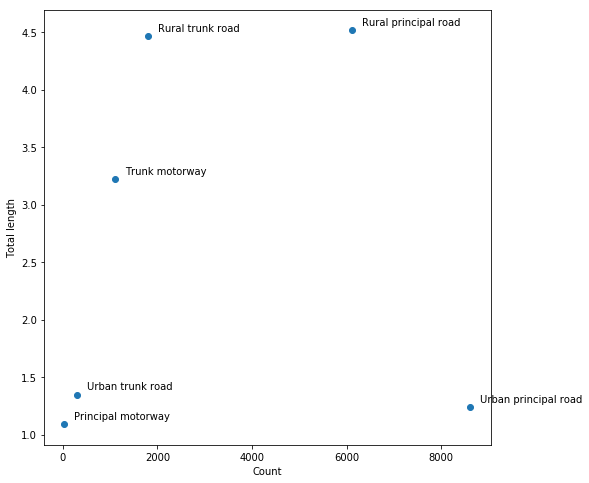

In [22]:
plt.scatter(road_lens_df['count'], 
            road_lens_df['length']
            )
plt.xlabel('Count')
plt.ylabel('Total length')
for r in road_lens_df.iterrows():
    plt.annotate(r[1]['category'], xy=(r[1]['count'], r[1]['length']),
                xytext=(10, 5), textcoords = 'offset points')
plt.show()

Unsurprisingly, rural road sections are longer than urban road sections. There are more "principal" than "trunk" road sections, probably because "trunk" roads are designated major routes.

But what are the principal motorways?

In [23]:
roads.distinct('Road', {'RCat': 'PM'})

['A57M',
 'M65',
 'A64M',
 'M62',
 'A329M',
 'A167M',
 'A601M',
 'M56',
 'M275',
 'A38M',
 'A58M',
 'M55']

The average lengths shown so far don't tell us about the distribution of lengths of different roads.

In [24]:
road_lengths_df = pd.DataFrame(list(roads.find({}, ['RCat', 'LenNet'])))
road_lengths_df.describe()

,LenNet
count,17987.000000
mean,2.799994
std,3.816937
min,0.070000
25%,0.600000
50%,1.500000
75%,3.300000
max,55.500000


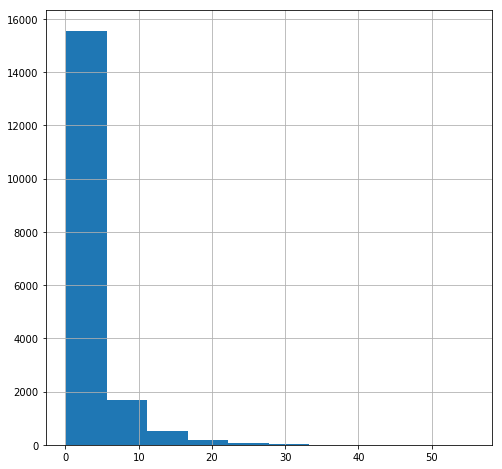

In [25]:
road_lengths_df['LenNet'].hist()

Most road sections are very short, with a few that are longer. 

Is there are difference between rural and urban sections?

In [26]:
isUrban = road_lengths_df.apply(lambda r: r['RCat'][1] == 'U', axis=1)
isRural = road_lengths_df.apply(lambda r: r['RCat'][1] == 'R', axis=1)

In [27]:
road_lengths_df[isUrban]['LenNet'].describe()

count    8920.000000
mean        1.242169
std         1.078233
min         0.070000
25%         0.400000
50%         0.900000
75%         1.700000
max        10.600000
Name: LenNet, dtype: float64

In [28]:
road_lengths_df[isRural]['LenNet'].describe()

count    7918.000000
mean        4.504208
std         4.949380
min         0.100000
25%         1.100000
50%         2.800000
75%         6.175000
max        55.500000
Name: LenNet, dtype: float64

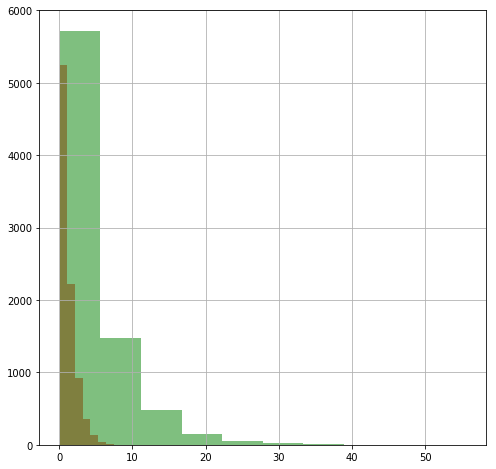

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

road_lengths_df[isUrban]['LenNet'].hist(ax=ax, alpha=0.5, color='red')
road_lengths_df[isRural]['LenNet'].hist(ax=ax, alpha=0.5, color='green')

This shows that, while both urban and rural roads have a similar shape of road length distributions (many short sections with some longer sections), the rural roads are much longer than the urban ones.

## Looing at districts
Which districts have the most roads, and the longest roads?

We'll use a pipeline to find the data and plot it on a scatter plot.

In [31]:
pipeline = [{'$group': {'_id': '$ONS LA Name',
                        'length': {'$sum': '$LenNet'},
                        'count': {'$sum': 1}}}]
results = list(roads.aggregate(pipeline))
results

[{'_id': 'Isles of Scilly', 'count': 5, 'length': 7.7},
 {'_id': 'Plymouth', 'count': 33, 'length': 42.0},
 {'_id': 'Havering', 'count': 33, 'length': 61.3},
 {'_id': 'Isle of Anglesey', 'count': 42, 'length': 174.1},
 {'_id': 'Newcastle upon Tyne', 'count': 78, 'length': 89.9},
 {'_id': 'Wakefield', 'count': 93, 'length': 203.96},
 {'_id': 'Calderdale', 'count': 65, 'length': 148.0},
 {'_id': 'York', 'count': 54, 'length': 96.32},
 {'_id': 'Conwy', 'count': 61, 'length': 232.9},
 {'_id': 'Trafford', 'count': 43, 'length': 67.9},
 {'_id': 'Lincolnshire', 'count': 201, 'length': 1108.11},
 {'_id': 'Halton', 'count': 43, 'length': 56.05},
 {'_id': 'Liverpool', 'count': 165, 'length': 124.4},
 {'_id': 'Barnsley', 'count': 76, 'length': 167.9},
 {'_id': 'Islington', 'count': 64, 'length': 38.1},
 {'_id': 'Bradford', 'count': 109, 'length': 154.7},
 {'_id': 'Kent', 'count': 466, 'length': 1134.94},
 {'_id': 'Warwickshire', 'count': 225, 'length': 619.0},
 {'_id': 'Cumbria', 'count': 206, 'l

In [32]:
ons_lens_df = pd.DataFrame(results)
ons_lens_df.set_index('_id', inplace=True)
ons_lens_df.index.name = 'LA'
ons_lens_df

,count,length
LA,,
Isles of Scilly,5,7.70
Plymouth,33,42.00
Havering,33,61.30
Isle of Anglesey,42,174.10
Newcastle upon Tyne,78,89.90
Wakefield,93,203.96
Calderdale,65,148.00
York,54,96.32
Conwy,61,232.90


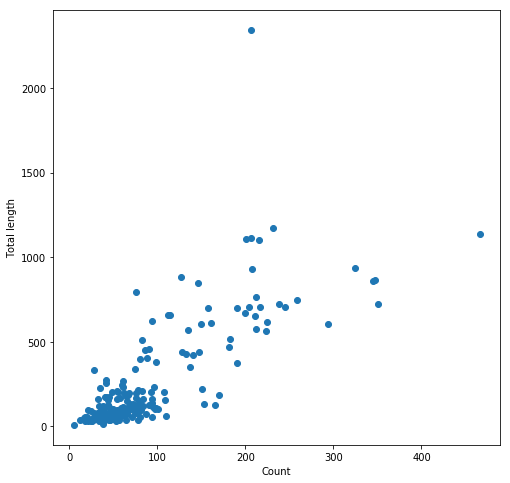

In [33]:
plt.scatter(ons_lens_df['count'], 
            ons_lens_df['length']
            )
plt.xlabel('Count')
plt.ylabel('Total length')
plt.show()

What are those two outliers (longest roads and most roads)?

In [34]:
# Which district has the most road sections?
ons_lens_df.loc[ons_lens_df['count'].idxmax()]

count      466.00
length    1134.94
Name: Kent, dtype: float64

In [35]:
# Which district has the longest total of road sections?
ons_lens_df.loc[ons_lens_df['length'].idxmax()]

count      206.0
length    2344.8
Name: Highland, dtype: float64

### Activity 1
Which districts have the most, and longest, road networks, when split between rural and urban?

Generate data that shows the number of road segments, and total length of road segments, grouped by both district and whether the road is rural or urban. Create scatter plots to show districts by rural road count vs urban road count, and rural road length vs urban road length. 

Comment on your findings.

**Hint**: You can tell is a road is rural or urban from the second character of the road category code, `R` or `U`. If you're using an aggregation pipeline to find the data, use `'class': {'$substr': ['$RCat', 1, 1]}` inside a `$project` stage to pick out the appropriate character.

The solution is in the [`15.3solutions`](15.3solutions.ipynb) Notebook.

In [ ]:
# Insert your solution here.

## Traffic volume distributions
What can we tell about how heavily used different roads are?

In [36]:
traffic_volume_df = pd.DataFrame(list(roads.find({}, ['Road', 'RCat', 'LenNet', 'FdAll_MV'])))
traffic_volume_df.describe()

,FdAll_MV,LenNet
count,17987.000000,17987.000000
mean,20543.581642,2.799994
std,21405.409276,3.816937
min,80.000000,0.070000
25%,8588.500000,0.600000
50%,14606.000000,1.500000
75%,23481.500000,3.300000
max,207485.000000,55.500000


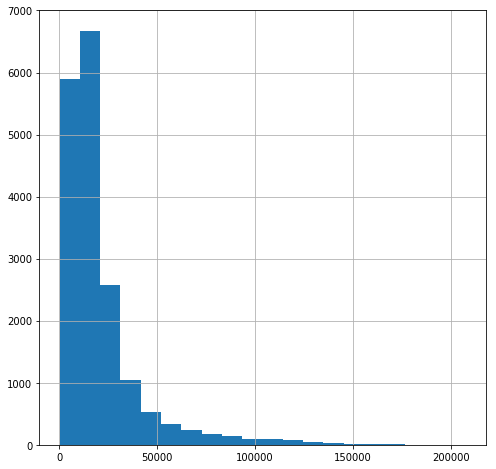

In [37]:
traffic_volume_df['FdAll_MV'].hist(bins=20)

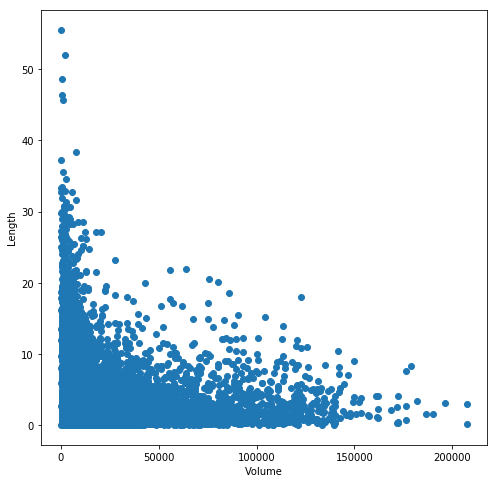

In [38]:
plt.scatter(traffic_volume_df['FdAll_MV'], 
            traffic_volume_df['LenNet']
            )
plt.xlabel('Volume')
plt.ylabel('Length')
plt.show()

In [39]:
isUrban = traffic_volume_df.apply(lambda r: r['RCat'][1] == 'U', axis=1)
isRural = traffic_volume_df.apply(lambda r: r['RCat'][1] == 'R', axis=1)

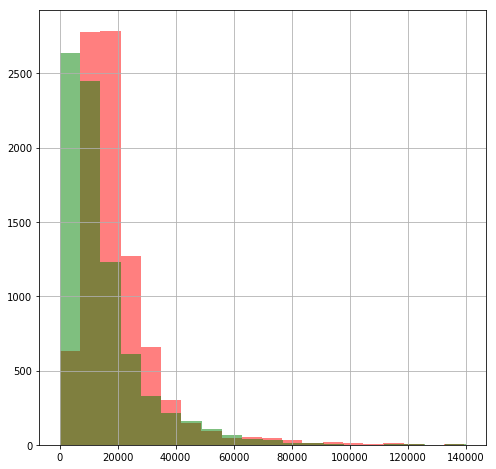

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

traffic_volume_df[isUrban]['FdAll_MV'].hist(ax=ax, alpha=0.5, color='red', bins=20)
traffic_volume_df[isRural]['FdAll_MV'].hist(ax=ax, alpha=0.5, color='green', bins=20)

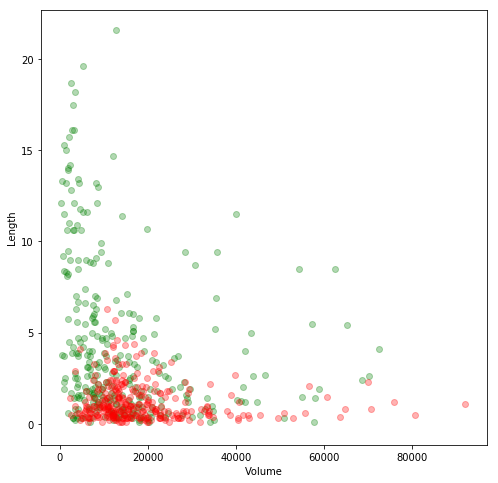

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)

rurals = traffic_volume_df[isRural].sample(300)
urbans = traffic_volume_df[isUrban].sample(300)

ax.scatter(rurals['FdAll_MV'], rurals['LenNet'],
           color='green', alpha=0.3
            )
ax.scatter(urbans['FdAll_MV'], urbans['LenNet'],
           color='red', alpha=0.3
            )

plt.xlabel('Volume')
plt.ylabel('Length')
plt.show()

This shows the different types of road use between rural and urban: urban roads tend to have higher volumes on shorter segments than rural areas.

In [1]:
# What road segment has the highest traffic?
traffic_volume_df.iloc[traffic_volume_df['FdAll_MV'].idxmax()]['Road']

NameError: name 'traffic_volume_df' is not defined

In [43]:
# What are the busiest road sections?
traffic_volume_df.sort_values(by='FdAll_MV', ascending=False).head(10)

,FdAll_MV,LenNet,RCat,Road,_id
12639,207485.0,0.2,TM,M25,533ed2c589f6f9ee18bb1b44
5412,207485.0,3.0,TM,M25,533ed2c589f6f9ee18baff09
9234,196279.0,3.1,TM,M25,533ed2c589f6f9ee18bb0df7
8176,190044.0,1.6,TM,M60,533ed2c589f6f9ee18bb09d5
4239,186726.0,1.6,TM,M1,533ed2c589f6f9ee18bafa74
7329,181764.0,3.5,TM,M25,533ed2c589f6f9ee18bb0686
1477,179080.0,8.4,TM,M25,533ed2c589f6f9ee18baefaa
1476,176572.0,7.7,TM,M25,533ed2c589f6f9ee18baefa9
2345,176274.0,2.7,TM,M60,533ed2c589f6f9ee18baf30e
12239,176274.0,0.8,TM,M60,533ed2c589f6f9ee18bb19b4


### Activity 2
Do different types of roads have different mixes of traffic? For each road category, find the average daily flow when averaged across all road segments of that category. Place the results in a DataFrame and plot them as a bar chart.

Investigate whether the mix of vehicle types is different on different road types. Use a suitable statistical test to determine if the differences you see are significant (you may want to refer back to Notebook 14.3).

Use just the total HGV counts, not the counts for each type of goods vehicle.

The solution is in the [`15.3solutions`](15.3solutions.ipynb) Notebook.

In [ ]:
# Insert your solution here.

## What next?
If you are working through this Notebook as part of an inline exercise, return to the module materials now.

If you are working through this set of Notebooks as a whole, move on to `15.4 Allocating accidents to roads`.